In [1294]:
import numpy as np
from PIL import Image, ImageFilter, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
from check import *
from numba import jit


In [1393]:
musicpath = 'music2.png'

In [1394]:
m = Image.open(musicpath).convert('L')
t = Image.open('template1.png').convert('L')

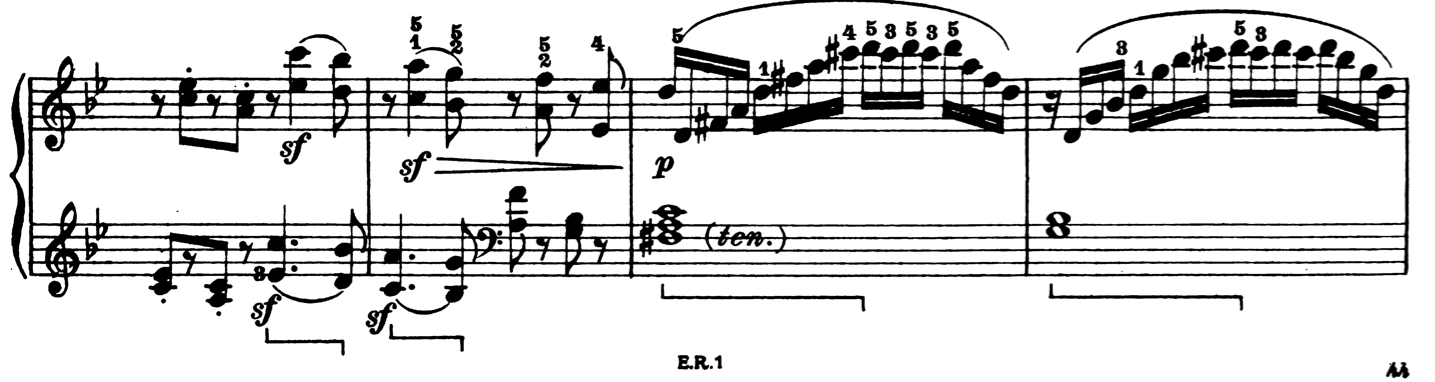

In [1395]:
m

In [1396]:
m = m.convert('1')
t = t.convert('1')

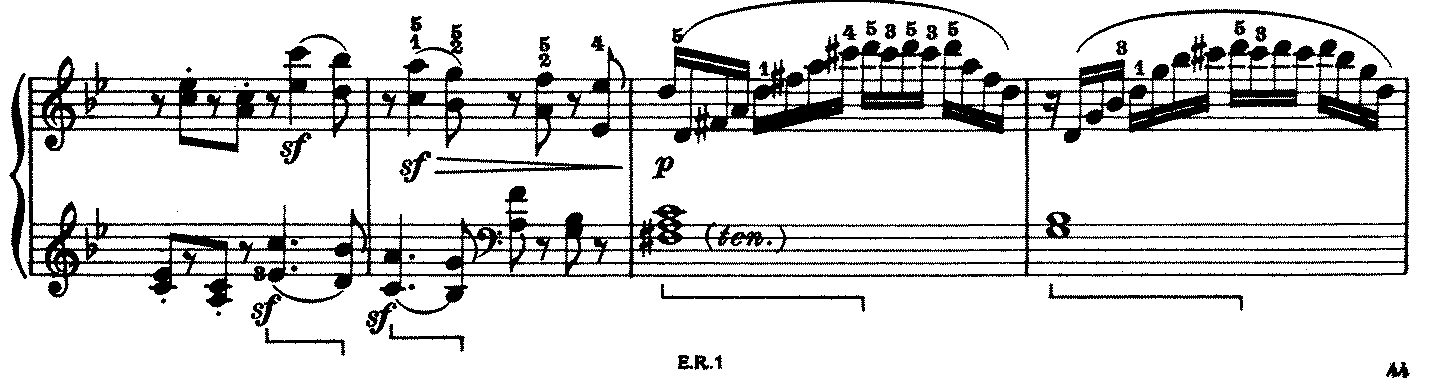

In [1397]:
m

In [1398]:
m_ = np.array(m)
t1_ = np.array(t)

In [1399]:
m_

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [1400]:
# m_ = 1 - m_/255.0
# t1_ = 1 - t1_/255.0

In [1401]:
scores = np.zeros((m_.shape[0], m_.shape[1]))

In [1402]:
m_[1][0]

True

In [1403]:
# calculate kernel size and matrix size
k_rows, k_cols = t1_.shape
m_rows, m_cols = m_.shape

# initialize result matrix with zeros
# scores = np.zeros((m_rows - k_rows + 1, m_cols - k_cols + 1))
scores = np.zeros((m_.shape[0], m_.shape[1]))

# slide kernel over matrix and calculate intersection over union
for i in range(m_rows - k_rows + 1):
    for j in range(m_cols - k_cols + 1):
        window = m_[i:i+k_rows, j:j+k_cols]
        intersection = np.sum(np.logical_and(t1_, window))
        union = np.sum(np.logical_or(t1_, window))
        iou = intersection / union
        scores[i][j] = iou

In [1383]:
# for y in range(m_.shape[0] - t1_.shape[0]):
#     for x in range(m_.shape[1] - t1_.shape[1]):
#         score = 0
#         for j in range(t1_.shape[0]):
#             for i in range(t1_.shape[1]):
#                 #score += (255 - t1_[j][i])/255.0 * (255-m_[y+j][x+i])/255.0
#                 score +=  t1_[j][i] * m_[y+j][x+i]
                
#         scores[y][x] = score

In [1404]:
max_score = scores.max()
max_score

0.711864406779661

In [1409]:
class note:

    def __init__(self, s_x, s_y, width, height, symbol, confidence, pitch = '_'):
        self.s_x = s_x
        self.s_y = s_y
        self.width = width
        self.height = height
        self.symbol = symbol
        self.confidence = confidence
        self.pitch = pitch

    def print(self):
        return (f"{self.s_x} {self.s_y} {self.height} {self.width} {self.symbol} {self.pitch} {self.confidence}")

In [1410]:
notes = []

In [1411]:
for y in range(m_.shape[0]):
    for x in range(m_.shape[1]):
        if scores[y][x] < max_score and scores[y][x] > .8 * max_score: # for template 2 .99
            notes.append(note(x, y, t1_.shape[1], t1_.shape[0],'filled_note', round(scores[y][x] / max_score * 100, 2)))

In [1412]:
len(notes)

56

In [1389]:
def calculate_overlap(note1, note2):
    # Calculate the overlap between two notes using the intersection over union (IoU) metric
    x1 = max(note1.s_x, note2.s_x)
    y1 = max(note1.s_y, note2.s_y)
    x2 = min(note1.s_x + note1.width, note2.s_x + note2.width)
    y2 = min(note1.s_y + note1.height, note2.s_y + note2.height)

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    union = note1.width * note1.height + note2.width * note2.height - intersection

    return intersection / union

In [1390]:
def non_max_suppression(notes, threshold):
    # Sort notes by decreasing height
    notes = sorted(notes, key=lambda note: note.height, reverse=True)

    # Create a list to store the selected notes
    selected_notes = []

    # Loop through each note in the sorted list
    for i, note in enumerate(notes):
        # Add the first note to the selected list
        if i == 0:
            selected_notes.append(note)
        else:
            # Calculate the overlap between the current note and the selected notes
            overlaps = [calculate_overlap(note, n) for n in selected_notes]
            # If the maximum overlap is below the threshold, add the current note to the selected list
            if max(overlaps) < threshold:
                selected_notes.append(note)

    return selected_notes

In [1391]:
notes_s = non_max_suppression(notes, .05)

In [1392]:
# Define the rectangle parameters
# x, y = 11, 904
width, height = 11, 17
img = Image.open(musicpath)
# Draw the rectangle on the image
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("Roboto-Black.ttf", size=20)
for note in notes_s:
    # draw.rectangle([note.s_y, note.s_x, note.s_y + note.width,  note.s_x + note.height], outline='red' )
    draw.rectangle([note.s_x, note.s_y, note.s_x + note.width,  note.s_y + note.height], outline='red' )
    draw.text((note.s_x - 15, note.s_y - 6), note.pitch, fill='red', font=font)

# Save the modified image
img.show()

In [722]:
img.save('Detected_.png')

In [723]:
trebble_dict = {-2.0: 'B', 
                -1.5: 'A',
                -1.0: 'G',
                -0.5: 'F',
                   0: 'E',
                 0.5: 'D',
                 1.0: 'C',
                 1.5: 'B',
                 2.0: 'A',
                 2.5: 'G',
                 3.0: 'F',
                 3.5: 'E',
                 4.0: 'D',
                 4.5: 'C',
                 5.0: 'B',
                }

In [724]:
staff_dict = {-2.0: 'D', 
              -1.5: 'C',
              -1.0: 'B',
              -0.5: 'A',
                 0: 'G',
               0.5: 'F',
               1.0: 'E',
               1.5: 'D',
               2.0: 'C',
               2.5: 'B',
               3.0: 'A',
               3.5: 'G',
               4.0: 'F',
               4.5: 'E',
               5.0: 'D',
            }

In [749]:
base = 30
staff_base = 150
dis = temp1.shape[0]

In [750]:
trebles = [30]
bases = [150]

In [751]:
for note in notes_s:
    base_note = note.s_y
    vis = 0
    for treble_pos in trebles:
        if base_note - treble_pos < 100:
            ratio = round((base_note - base) / dis, 2)
            # print(ratio)
            min_dis = 55
            key = ''
            for i in range(-20, 55, 5):
                window = i / 10
                if abs(ratio - window) < min_dis:
                    min_dis = abs(ratio - window)
                    key = i / 10
            print(base_note, " ", round((base_note - base) / dis, 2))
            note.pitch = trebble_dict[key]
            vis = 1
    
    if vis == 0:
        for base_pos in bases:
            if base_note - base_pos < 100:
                ratio = round((base_note - staff_base) / dis, 2)
                # print(ratio)
                min_dis = 55
                key = ''
                for i in range(-20, 55, 5):
                    window = i / 10
                    if abs(ratio - window) < min_dis:
                        min_dis = abs(ratio - window)
                        key = i / 10
                note.pitch = staff_dict[key]

36   0.55
36   0.55
36   0.55
36   0.55
36   0.55
36   0.55
47   1.55
47   1.55
47   1.55
47   1.55
47   1.55
47   1.55
47   1.55
47   1.55
47   1.55
47   1.55
53   2.09
53   2.09
59   2.64
59   2.64
59   2.64
59   2.64
59   2.64
59   2.64
76   4.18
76   4.18
87   5.18


In [744]:
for note in notes_s:
    base_note = note.s_y

    if base_note - base < 100:
        ratio = round((base_note - base) / dis, 2)
        # print(ratio)
        min_dis = 55
        key = ''
        for i in range(-20, 55, 5):
            window = i / 10
            if abs(ratio - window) < min_dis:
                min_dis = abs(ratio - window)
                key = i / 10
        note.pitch = trebble_dict[key]
    
    else:
        ratio = round((base_note - staff_base) / dis, 2)
        # print(ratio)
        min_dis = 55
        key = ''
        for i in range(-20, 55, 5):
            window = i / 10
            if abs(ratio - window) < min_dis:
                min_dis = abs(ratio - window)
                key = i / 10
        note.pitch = staff_dict[key]

In [747]:
for note in notes_s:
    print(note.print())

319 36 11 17 filled_note D 91.85
354 36 11 17 filled_note D 91.85
389 36 11 17 filled_note D 91.85
755 36 11 17 filled_note D 91.9
790 36 11 17 filled_note D 91.9
825 36 11 17 filled_note D 91.9
179 47 11 17 filled_note B 93.53
214 47 11 17 filled_note B 93.52
249 47 11 17 filled_note B 91.74
424 47 11 17 filled_note B 91.75
494 47 11 17 filled_note B 91.75
615 47 11 17 filled_note B 93.2
650 47 11 17 filled_note B 93.18
685 47 11 17 filled_note B 91.78
860 47 11 17 filled_note B 91.78
929 47 11 17 filled_note B 91.74
458 53 11 17 filled_note A 90.78
893 53 11 17 filled_note A 90.73
109 59 11 17 filled_note G 93.62
284 59 11 17 filled_note G 91.84
545 59 11 17 filled_note G 93.31
720 59 11 17 filled_note G 91.89
980 59 11 17 filled_note G 93.54
1082 59 11 17 filled_note G 93.32
143 76 11 17 filled_note C 90.8
579 76 11 17 filled_note C 90.9
1081 87 11 17 filled_note B 91.8
459 134 11 17 filled_note C 92.02
894 134 11 17 filled_note C 91.99
109 139 11 17 filled_note B 91.63
545 139 11 1

In [731]:
# Open the file in write mode
file = open("myfile.txt", "w")

# Write values to the file
file.write(notes_s[0].print())
file.write("1234\n")
file.write("3.1415\n")

# Close the file
file.close()

In [662]:
x = notes_s[0].print()

In [663]:
x

'319 36 11 17 filled_note D 91.85'